# Mogi source forward model for calbuco

In [45]:
import numpy as np
import rasterio
import iscefunctions as util
import os
import pyproj
from collections import OrderedDict
import mogi

import matplotlib.pyplot as plt
%matplotlib inline
#%qtconsole

In [2]:
# Point to where data is stored
datadir = './data_8lks/'
nlks = '8alks_8rlks'
unwFile = 'filt_topophase.unw.{}.geo.vrt'.format(nlks)
#demFile = 'dem.{}.crop.vrt'.format(nlks)
losFile = 'los.rdr.{}.geo.vrt'.format(nlks)
corFile = 'phsig.cor.{}.geo.vrt'.format(nlks)
concompFile = 'filt_topophase.unw.conncomp.{}.geo'.format(nlks)

In [6]:
# Convert to UTM for modeling
os.chdir(datadir)
for file in [unwFile, demFile, losFile, corFile, concompFile]:
    output = file.replace('geo', 'utm')
    os.system('gdalwarp -of VRT -t_srs EPSG:32718 {0} {1}'.format(file, output))
os.chdir('../')

In [9]:
# Work with UTM for modeling
unwFile = unwFile.replace('geo','utm')
corFile = corFile.replace('geo','utm')
losFile = losFile.replace('geo','utm')

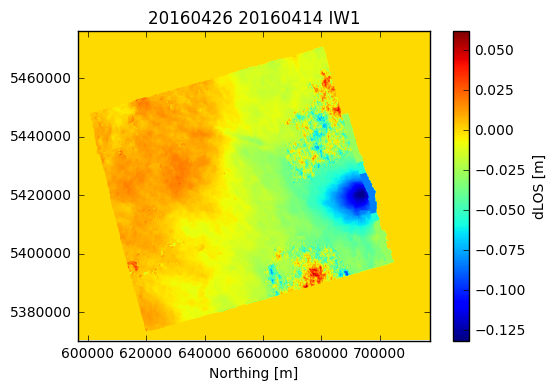

In [61]:

# Plot the LOS displacements
data,extent,metadata = util.load_rasterio(datadir + unwFile)
amp,phs = data
mm = phs*0.05546576/12.5663706  #leep in meters for modeling
pCalbuco = (-72.614, -41.326)

plt.imshow(mm, extent=extent)
plt.plot(pCalbuco[0], pCalbuco[1], 'k^', scalex=False, scaley=False)
cb = plt.colorbar()
plt.title('20160426 20160414 IW1')
plt.xlabel("Easting [m]")
plt.xlabel("Northing [m]")
cb.set_label('dLOS [m]')


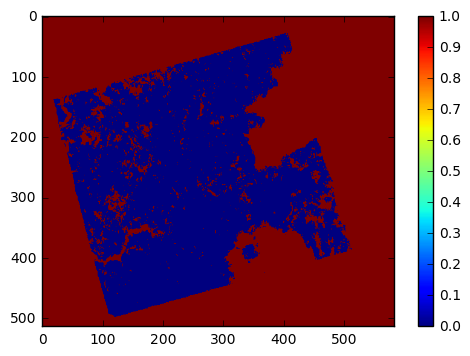

In [37]:
# Use coherence file as mask
data, extent, meta = util.load_rasterio(datadir + corFile)
cor = data[0]
#cor[cor==0] = np.nan
mask = (cor < 0.5)
plt.imshow(mask)
plt.colorbar()

In [62]:
# Load auxilary files and mask
data, extent, meta = util.load_rasterio(datadir + losFile)
incidence = data[0]
heading = data[1]

incidence[mask] = np.nan
heading[mask] = np.nan
mm[mask] = np.nan

In [57]:
# Check /plot data before modeling
def plot_3(array1,array2,array3):
    ''' plot auxilary files '''
    # a few simple plots
    # http://stackoverflow.com/questions/32633322/changing-aspect-ratio-of-subplots-in-matplotlib
    fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,10), subplot_kw=dict(adjustable='box-forced'))
    cs = 0.4 #colorbar shrink (vertical)
    ax = axes[0]
    im = ax.imshow(array1, extent=extent, cmap='viridis')
    plt.colorbar(im, ax=ax, shrink=cs)

    ax = axes[1]
    im = ax.imshow(array2, extent=extent, cmap='viridis')
    plt.colorbar(im, ax=ax, shrink=cs)

    ax = axes[2]
    im = ax.imshow(array3, extent=extent, cmap='viridis')
    plt.colorbar(im, ax=ax, shrink=cs)
    
    #Add a particular point (e.g. Calbuco summit)
    p = (-72.614, -41.326)
    for ax in axes:
        ax.plot(p[0], p[1], 'k^', scalex=False, scaley=False)

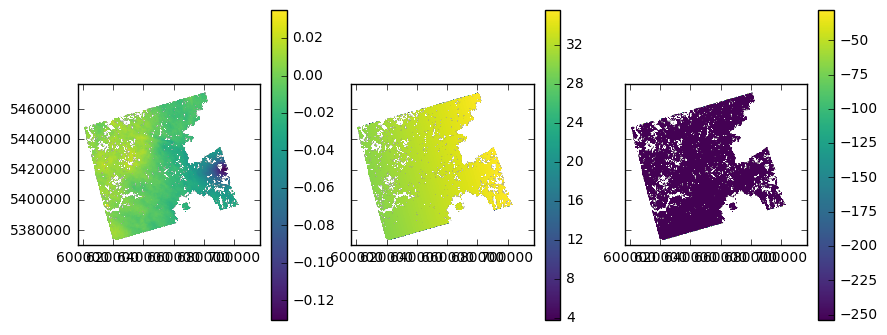

In [63]:
plot_3(mm,incidence,heading)

In [68]:
# Run a forward model!
lat_cen = -41.326
lon_cen = -72.614
p = pyproj.Proj(proj='utm',zone=18,south=True,ellps='WGS84')
xcen,ycen = p(lon_cen,lat_cen)

# Set up grid (pixel center coordinates)
r,c = np.indices(mm.shape)
eastings, northings = util.world2rc(c,r,meta['affine'], inverse=True)


# Forward Model 1
# ----------------
params = OrderedDict([('xcen',xcen),
            ('ycen',ycen),
            ('d', 10e3), #m
            ('dV', -1e7), #m^3
            ])

ux,uy,uz = mogi.forward(eastings, northings, **params)

#NOTE: make sure conventions correct (in particular heading in ISCE vs ROI)
cart2los = -util.get_cart2los(incidence, heading)
dataVec = np.dstack([ux, uy, uz])
model = np.sum(dataVec * cart2los, axis=2)

In [66]:
# Plot EW Profile
def plot_model(mm,model):
    fig, axes = plt.subplots(1,2,sharex=True,sharey=True, figsize=(10,6))
    im = axes[0].imshow(mm, extent=extent, cmap='bwr') #extent=None
    axes[0].plot(xcen,ycen,'k^', label='Calbuco Summit')
    #axes[0].axhline(north,color='k')
    axes[1].imshow(model, extent=extent, vmin=-0.1, vmax=0.1, cmap='bwr')
    axes[1].plot(params['xcen'],params['ycen'],'ko', label='Model Centroid')
    axes[0].grid(True); axes[1].grid(True)
    cb = fig.colorbar(im, ax=axes.ravel().tolist())
    cb.set_label('m')
    #plt.savefig('initial_guess.png')

    north = 5420000
    east = 0
    row, col = util.world2rc(east,north,meta['affine'])

    plt.figure(figsize=(8,4))
    plt.plot(eastings[row], mm[row],'k.-', label='data')
    plt.plot(eastings[row], model[row],'r-', label='initial guess')
    plt.xlabel('Easting [m]')
    plt.ylabel('dLOS [m]')
    plt.grid(True)

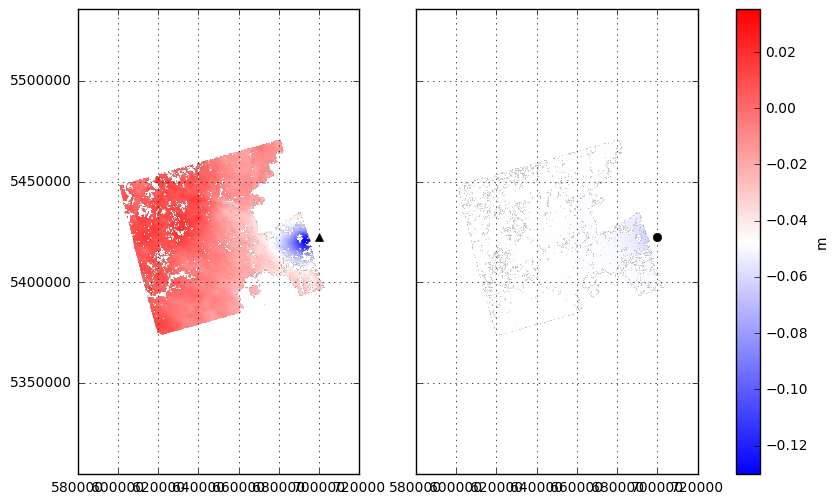

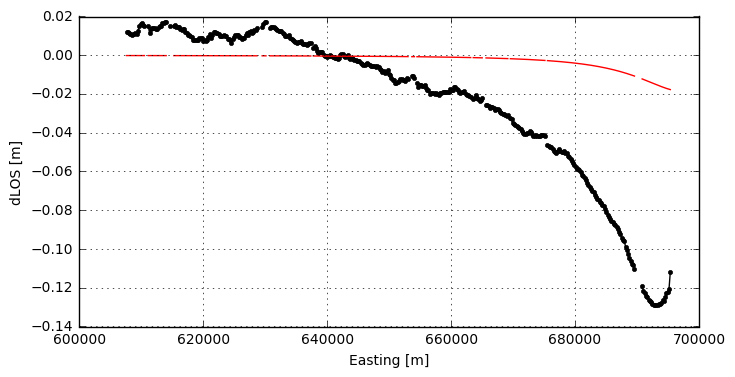

In [67]:
plot_model(mm,model)

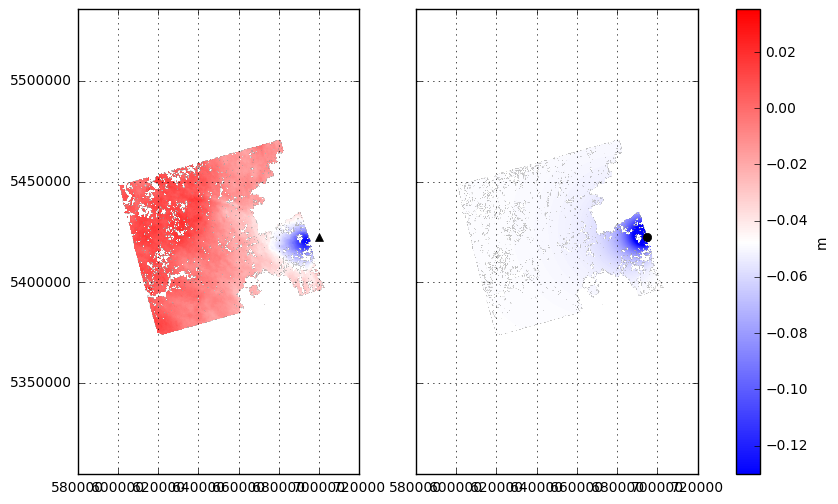

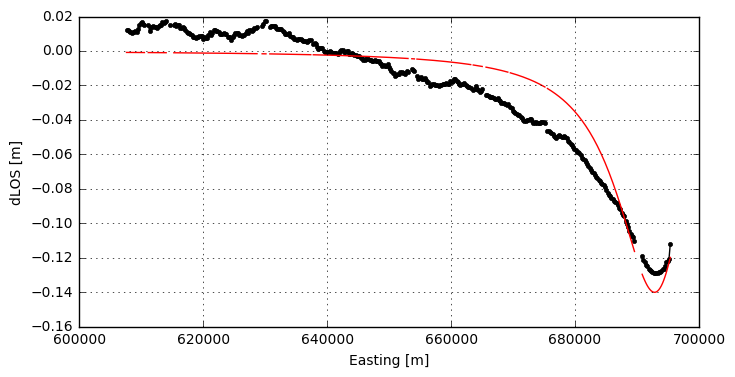

In [69]:
# Forward Model 2
# ----------------
params = OrderedDict([('xcen',xcen-5e3),
            ('ycen',ycen),
            ('d', 8e3), #m
            ('dV', -5e7), #m^3
            ])

ux,uy,uz = mogi.forward(eastings, northings, **params)

#NOTE: make sure conventions correct (in particular heading in ISCE vs ROI)
cart2los = -util.get_cart2los(incidence, heading)
dataVec = np.dstack([ux, uy, uz])
model = np.sum(dataVec * cart2los, axis=2)

plot_model(mm, model)

In [79]:
from scipy.optimize import curve_fit

# Inversion
# Nonlinear Least Squares Inversion
# ----------------
initial_guess = list(params.values())
valid = np.isfinite(mm) & np.isfinite(incidence) & np.isfinite(heading)
data = mm[valid]
xargs = [eastings[valid], northings[valid], incidence[valid], heading[valid]]


popt,pcov,info,mes,flag = curve_fit(mogi.invert, 
                                   xargs, 
                                   data, 
                                   p0=initial_guess,
                                   full_output=True)

rmse=np.sqrt(np.sum( (data-info['fvec'])**2 ) / data.size)
print('Inversion Info:')
print(meta['crs'])
print('Number of Function Calls= {nfev}'.format(**info))
print('RMSE [m]= {:3f}'.format(rmse))

In [101]:
def print_inversion_results(popt,pcov):
    print('Best Fit Parameters:')
    print('Easting= {:.2e} [m]'.format(popt[0]))
    print('Northing= {:.2e} [m]'.format(popt[1]))
    print('Depth= {:.2e} [m]'.format(popt[2]))
    print('dV= {:.2e} [m^3]'.format(popt[3]))
    print('nu= 0.25')

    perr = np.sqrt(np.diag(pcov))
    print('Parameter 1 std Error:')
    print('Easting= {:.4e} [m]'.format(perr[0]))
    print('Northing= {:.4e} [m]'.format(perr[1]))
    print('Depth= {:.4e} [m]'.format(perr[2]))
    print('dV= {:.4e} [m^3]'.format(perr[3]))
    print('nu= 0.25')

In [102]:
print_inversion_results(popt,pcov)

Best Fit Parameters:
Easting= 6.96e+05 [m]
Northing= 5.42e+06 [m]
Depth= 1.60e+04 [m]
dV= -1.30e+08 [m^3]
nu= 0.25
Parameter 1 std Error:
Easting= 4.6038e+01 [m]
Northing= 2.8823e+01 [m]
Depth= 3.5103e+01 [m]
dV= 4.5918e+05 [m^3]
nu= 0.25


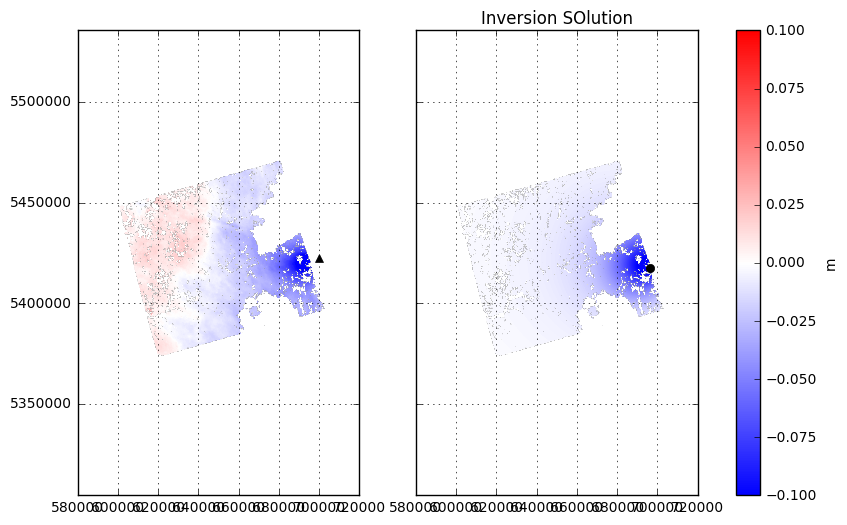

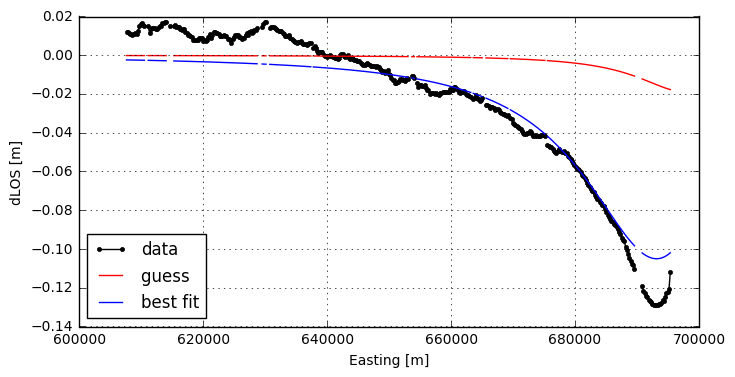

In [84]:
# re-run forward model with best-fit parameters
#los_fit = info['fvec']
ux,uy,uz = mogi.forward(eastings, northings, *popt)
dataVec = np.dstack([ux, uy, uz])
losmodel = np.sum(dataVec * cart2los, axis=2)
#plot_result(los, losmodel)

fig, axes = plt.subplots(1,2,sharex=True,sharey=True, figsize=(10,6))
im = axes[0].imshow(mm, vmin=-0.1, vmax=0.1, extent=extent, cmap='bwr')
axes[0].plot(xcen,ycen,'k^', label='Calbuco Summit')
axes[1].imshow(losmodel, extent=extent, vmin=-0.1, vmax=0.1, cmap='bwr')
axes[1].plot(popt[0],popt[1],'ko', label='Model Centroid')
axes[0].grid(True); axes[1].grid(True)
plt.title('Inversion Solution')
cb = fig.colorbar(im, ax=axes.ravel().tolist())
cb.set_label('m')
plt.savefig('inversion_map.png')


plt.figure(figsize=(8,4))
plt.plot(eastings[row], mm[row],'k.-', label='data')
plt.plot(eastings[row], losguess[row],'r-', label='guess ')
plt.plot(eastings[row], losmodel[row],'b-', label='best fit')
plt.xlabel('Easting [m]')
plt.ylabel('dLOS [m]')
plt.legend(loc='lower left')
plt.grid(True)

In [99]:
# simple stack
def calc_ramp(array, mask):
    ''' calculate best-fitting bilinear ramp across array '''
    X,Y = np.indices(array.shape) 
    x = X.reshape((-1,1))
    y = Y.reshape((-1,1))

    phs = np.ma.masked_invalid(array)
    phs[mask] = np.ma.masked
    
    d = phs.reshape((-1,1))
    g = ~d.mask
    dgood = d[g].reshape((-1,1))
    
    G = np.concatenate([x, y, x*y, np.ones_like(x)], axis=1)
    Ggood = np.vstack([x[g], y[g], x[g]*y[g], np.ones_like(x[g])]).T  
    m,resid,rank,s = np.linalg.lstsq(Ggood,dgood)
    
    ramp = np.dot(G,m)
    ramp = ramp.reshape(phs.shape)
    
    return ramp   

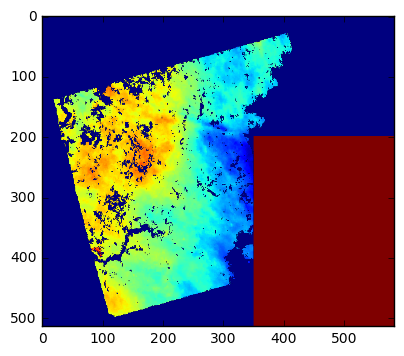

In [95]:
# first mask signal
mask_signal = np.zeros_like(mm).astype('bool')
mask_signal[200:,350:] = 1
plt.imshow(mm)
plt.imshow(mask_signal)
test = mm.copy()
test[mask_signal] = np.nan
plt.imshow(test)

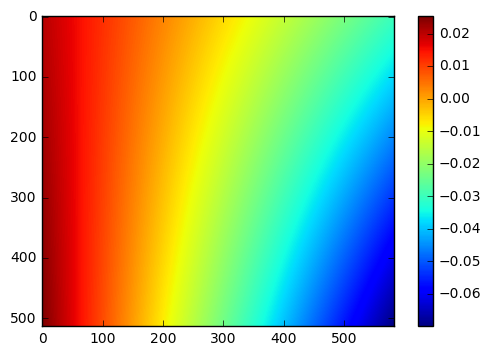

In [100]:
ramp = calc_ramp(mm, mask_signal)
plt.imshow(ramp)
plt.colorbar()

In [103]:
mm_deramp = mm - ramp

# Inversion
# Nonlinear Least Squares Inversion
# ----------------
initial_guess = list(params.values())
valid = np.isfinite(mm_deramp) & np.isfinite(incidence) & np.isfinite(heading)
data = mm_deramp[valid]
xargs = [eastings[valid], northings[valid], incidence[valid], heading[valid]]


popt,pcov,info,mes,flag = curve_fit(mogi.invert, 
                                   xargs, 
                                   data, 
                                   p0=initial_guess,
                                   full_output=True)

rmse=np.sqrt(np.sum( (data-info['fvec'])**2 ) / data.size)
print('Inversion Info:')
print(meta['crs'])
print('Number of Function Calls= {nfev}'.format(**info))
print('RMSE [m]= {:3f}'.format(rmse))

Inversion Info:
CRS({'init': 'epsg:32718'})
Number of Function Calls= 41
RMSE [m]= 0.016110


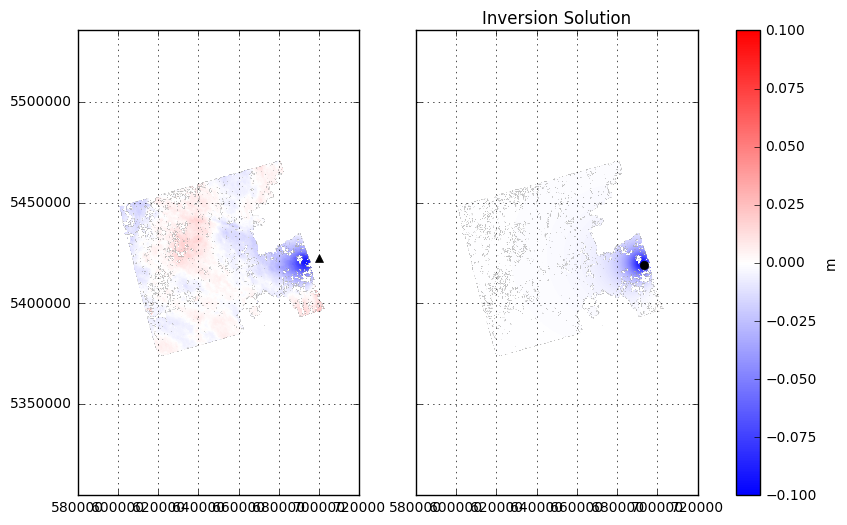

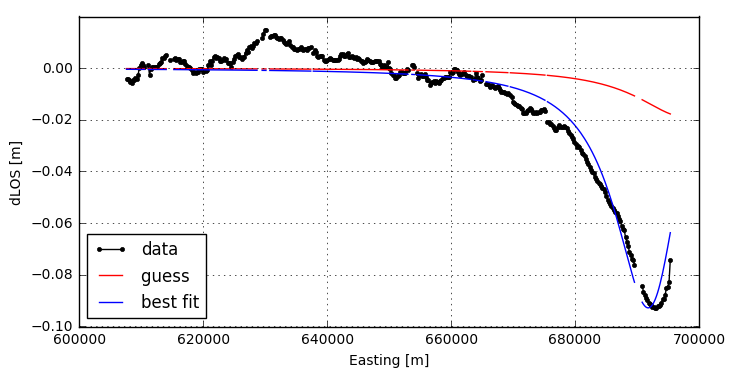

In [105]:
# re-run forward model with best-fit parameters
#los_fit = info['fvec']
ux,uy,uz = mogi.forward(eastings, northings, *popt)
dataVec = np.dstack([ux, uy, uz])
losmodel = np.sum(dataVec * cart2los, axis=2)
#plot_result(los, losmodel)

fig, axes = plt.subplots(1,2,sharex=True,sharey=True, figsize=(10,6))
im = axes[0].imshow(mm_deramp, vmin=-0.1, vmax=0.1, extent=extent, cmap='bwr')
axes[0].plot(xcen,ycen,'k^', label='Calbuco Summit')
axes[1].imshow(losmodel, extent=extent, vmin=-0.1, vmax=0.1, cmap='bwr')
axes[1].plot(popt[0],popt[1],'ko', label='Model Centroid')
axes[0].grid(True); axes[1].grid(True)
plt.title('Inversion Solution')
cb = fig.colorbar(im, ax=axes.ravel().tolist())
cb.set_label('m')
plt.savefig('inversion_map.png')


plt.figure(figsize=(8,4))
plt.plot(eastings[row], mm_deramp[row],'k.-', label='data')
plt.plot(eastings[row], losguess[row],'r-', label='guess ')
plt.plot(eastings[row], losmodel[row],'b-', label='best fit')
plt.xlabel('Easting [m]')
plt.ylabel('dLOS [m]')
plt.legend(loc='lower left')
plt.grid(True)

In [106]:
print_inversion_results(popt,pcov)

Best Fit Parameters:
Easting= 6.93e+05 [m]
Northing= 5.42e+06 [m]
Depth= 7.38e+03 [m]
dV= -2.46e+07 [m^3]
nu= 0.25
Parameter 1 std Error:
Easting= 2.0174e+01 [m]
Northing= 1.5690e+01 [m]
Depth= 2.1203e+01 [m]
dV= 9.5478e+04 [m^3]
nu= 0.25
